# imports

In [ ]:
pip install facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.

In [ ]:
pip install tqdm seaborn


ERROR: Operation cancelled by user
^C


In [ ]:
pip install numpy

In [ ]:
import torch
import numpy as np
import pandas as pd
import cv2
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image


# Initialization

In [ ]:
ROOT = Path("/content/drive/MyDrive/EECS5322_prj/Project 9 - attentive face recognition")
GALLERY_DIR = ROOT / "gallery"
WILD_IMG_DIR = ROOT / "queries"
GROUND_TRUTH_CSV = ROOT / "ground_truth.csv"  # contains filename, True_ID
save_path = "/content/drive/MyDrive/EECS5322_prj/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize MTCNN detector + FaceNet embedding model
mtcnn = MTCNN(image_size=160, margin=20, device=device)
facenet = InceptionResnetV1(pretrained="vggface2").eval().to(device)


  0%|          | 0.00/107M [00:00<?, ?B/s]

# build gallery

In [ ]:
def load_image(path):
    img = cv2.imread(str(path))
    if img is None:
        raise FileNotFoundError(f"Cannot load image {path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def get_embedding(img):
    face = mtcnn(img) ## detect faces
    if face is None:
        return None
    face = face.unsqueeze(0).to(device)
    with torch.no_grad():
        emb = facenet(face).cpu().numpy().flatten() ## embed using facenet
    return emb / np.linalg.norm(emb)  # L2 normalize

def build_gallery(gallery_dir):
    gallery = {}
    person_dirs = sorted([d for d in gallery_dir.iterdir() if d.is_dir()])
    for person_dir in tqdm(person_dirs, desc="Building gallery"):
        pid = int(person_dir.name)  # assuming folder names 0-6
        gallery[pid] = []
        for img_path in sorted(person_dir.glob("*.jpg")):
            img = load_image(img_path)
            emb = get_embedding(img)
            if emb is None:
                print(f"[Warning] No face detected in {img_path}")
                continue
            gallery[pid].append(emb)
        gallery[pid] = np.array(gallery[pid])
    return gallery

print("=== Building Gallery ===")
gallery = build_gallery(GALLERY_DIR)
print("Gallery identities:", list(gallery.keys()))

=== Building Gallery ===


Building gallery: 100%|██████████| 7/7 [05:50<00:00, 50.03s/it]

Gallery identities: [0, 1, 2, 3, 4, 5, 6]


# Define quality metrics and enhancement

## compute quality score

In [ ]:
import cv2
import numpy as np

def compute_quality(img):
    """
    Compute simple quality metrics for an image:
    - Sharpness: Laplacian variance
    - Brightness: mean of grayscale
    - Contrast: standard deviation of grayscale
    Returns a tuple: (lap_var, brightness, contrast)
    """
    # Convert RGB image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sharpness: Laplacian variance
    lap_var = cv2.Laplacian(gray, cv2.CV_64F).var()

    # Brightness: mean intensity
    brightness = gray.mean()

    # Contrast: standard deviation of intensity
    contrast = gray.std()

    return lap_var, brightness, contrast


In [ ]:
img_path = "/content/drive/MyDrive/EECS5322_prj/Project 9 - attentive face recognition/queries/04_01.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

lap_var, brightness, contrast = compute_quality(img)
print(f"Sharpness: {lap_var:.2f}, Brightness: {brightness:.2f}, Contrast: {contrast:.2f}")


Sharpness: 27.09, Brightness: 67.96, Contrast: 65.35


In [ ]:
def compute_quality_score(lap_var, brightness, contrast):
    """
    Normalize quality metrics and compute a single quality score Q ∈ [0,1]
    """
    # Normalize Laplacian variance (sharpness)
    lap_norm = np.clip(lap_var / 200.0, 0, 1)  # adjust 200 based on your dataset

    # Normalize brightness (assuming images are ~0-255)
    brightness_norm = np.clip((brightness - 50) / 150, 0, 1)  # shifts low brightness to 0

    # Normalize contrast (std of grayscale)
    contrast_norm = np.clip(contrast / 100, 0, 1)  # adjust 100 based on dataset

    # Combine all three metrics
    Q = (lap_norm + brightness_norm + contrast_norm) / 3.0
    return Q


In [ ]:
Q = compute_quality_score(lap_var, brightness, contrast)
print(f"Quality score Q: {Q:.3f}")


Quality score Q: 0.303


The idea:

If the image is blurry (low sharpness / low Q), we enhance it.

Enhancement pipeline:

CLAHE for adaptive contrast improvement.

Unsharp mask for edge sharpening.

## enhance images classic methods

In [ ]:
import cv2
import numpy as np

def enhance_classical(img_rgb):
    """
    Apply classical enhancement to a face image:
    1. Denoise
    2. CLAHE (contrast)
    3. Sharpening
    Input: RGB image (H,W,3)
    Output: Enhanced RGB image
    """

    # --- 1. Denoising ---
    bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    denoised = cv2.fastNlMeansDenoisingColored(bgr, None, 10, 10, 7, 21)
    img = cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB)

    # --- 2. CLAHE ---
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    L, A, B = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    L_clahe = clahe.apply(L)
    lab_clahe = cv2.merge((L_clahe, A, B))
    img = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

    # --- 3. Sharpening ---
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(img, -1, kernel)

    return sharpened


In [ ]:
def preprocess_image(img, lap_var_threshold=100.0):
    """
    Preprocess an image based on quality:
    - Compute quality metrics
    - If Laplacian variance < threshold, enhance image
    Returns:
        - processed image
        - quality score Q ∈ [0,1]
    """
    # Compute quality metrics
    lap_var, brightness, contrast = compute_quality(img)

    # Compute quality score
    Q = compute_quality_score(lap_var, brightness, contrast)

    # Apply enhancement if image is blurry
    if lap_var < lap_var_threshold:
        img = enhance_classical(img)

    return img, Q


========before========
Sharpness: 27.09, Brightness: 67.96, Contrast: 65.35
Processed image quality score Q was : 0.303
========After========
Sharpness: 875.15, Brightness: 85.08, Contrast: 69.16
Quality score new Q: 0.642


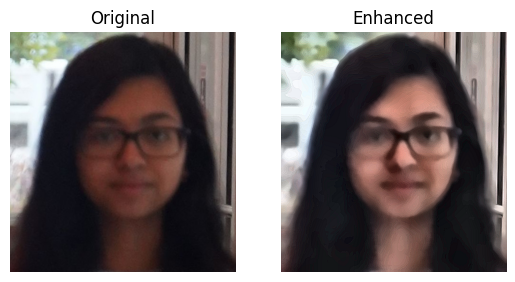

In [ ]:
img_path = "/content/drive/MyDrive/EECS5322_prj/Project 9 - attentive face recognition/queries/04_01.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print("========before========")
lap_var, brightness, contrast = compute_quality(img)
print(f"Sharpness: {lap_var:.2f}, Brightness: {brightness:.2f}, Contrast: {contrast:.2f}")

img_proc, Q_before = preprocess_image(img)
print(f"Processed image quality score Q was : {Q:.3f}")

print("========After========")
lap_var, brightness, contrast = compute_quality(img_proc)
print(f"Sharpness: {lap_var:.2f}, Brightness: {brightness:.2f}, Contrast: {contrast:.2f}")
Q_new = compute_quality_score(lap_var, brightness, contrast)
print(f"Quality score new Q: {Q_new:.3f}")

# Optional: view before/after
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_proc)
plt.title("Enhanced")
plt.axis('off')
plt.show()


## enhancing with super resolution: did not improve

In [ ]:
import cv2
from cv2 import dnn_superres

# Initialize SR
sr = dnn_superres.DnnSuperResImpl_create()
sr.readModel("/content/drive/MyDrive/EECS5322_prj/models/ESPCN_x4.pb")  # make sure path is correct
sr.setModel("espcn", 4)  # 2x upscaling



In [ ]:
def enhance_images(img_rgb, sr_model):
    img_out = img_rgb.copy()
    try:
        # Ensure correct dtype and channels
        if img_rgb.dtype != np.uint8:
            img_rgb = (img_rgb * 255).astype(np.uint8)  # if float
        if img_rgb.shape[2] == 4:  # RGBA
            img_rgb = img_rgb[:, :, :3]

        bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
        sr_bgr = sr_model.upsample(bgr)
        img_out = cv2.cvtColor(sr_bgr, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"[Warning] SR failed: {e}")
    return img_out


In [ ]:
def preprocess_image_final(img, lap_var_threshold=100.0):
    """
    Preprocess an image based on quality:
    - Compute quality metrics
    - If Laplacian variance < threshold, enhance image
    Returns:
        - processed image
        - quality score Q ∈ [0,1]
    """
    # Compute quality metrics
    lap_var, brightness, contrast = compute_quality(img)

    # Compute quality score
    Q = compute_quality_score(lap_var, brightness, contrast)

    # Apply enhancement if image is blurry
    if lap_var < lap_var_threshold:
        img = enhance_images(img, sr)

    return img, Q


========before========
Sharpness: 27.09, Brightness: 67.96, Contrast: 65.35
Processed image quality score Q was : 0.303
========After========
Sharpness: 1.79, Brightness: 67.86, Contrast: 65.32
Quality score new Q: 0.260


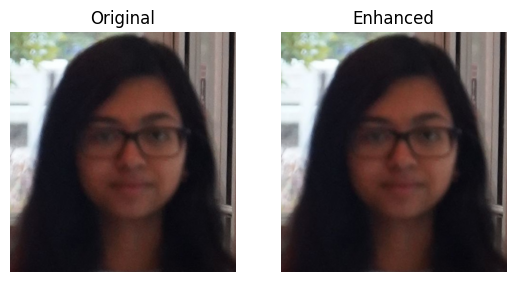

In [ ]:
img_path = "/content/drive/MyDrive/EECS5322_prj/Project 9 - attentive face recognition/queries/04_01.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print("========before========")
lap_var, brightness, contrast = compute_quality(img)
print(f"Sharpness: {lap_var:.2f}, Brightness: {brightness:.2f}, Contrast: {contrast:.2f}")

img_proc, Q_before = preprocess_image_final(img)
print(f"Processed image quality score Q was : {Q:.3f}")

print("========After========")
lap_var, brightness, contrast = compute_quality(img_proc)
print(f"Sharpness: {lap_var:.2f}, Brightness: {brightness:.2f}, Contrast: {contrast:.2f}")
Q_new = compute_quality_score(lap_var, brightness, contrast)
print(f"Quality score new Q: {Q_new:.3f}")

# Optional: view before/after
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_proc)
plt.title("Enhanced")
plt.axis('off')
plt.show()


In [ ]:
import cv2
from cv2 import dnn_superres
import numpy as np

img = cv2.imread(img_path)  # BGR
sr = dnn_superres.DnnSuperResImpl_create()
sr.readModel("/content/drive/MyDrive/EECS5322_prj/models/ESPCN_x4.pb")
sr.setModel("espcn", 4)

# Ensure 3 channels and uint8
if img.shape[2] == 4:
    img = img[:, :, :3]
img = img.astype(np.uint8)

upscaled = sr.upsample(img)
cv2.imwrite("upscaled.jpg", upscaled)


True

## brightness and sharpening

In [ ]:
# --- helper functions ---
def adjust_gamma(img, gamma=1.2):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255
                      for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(img, table)

def unsharp_mask(img, kernel_size=(5,5), sigma=1.0, amount=1.0):
    blurred = cv2.GaussianBlur(img, kernel_size, sigma)
    sharpened = cv2.addWeighted(img, 1 + amount, blurred, -amount, 0)
    return sharpened

In [ ]:
import cv2
import numpy as np

def enhance_classical_v2(img_rgb):
    """
    Enhanced classical image processing pipeline:
    1. Denoise
    2. CLAHE (local contrast)
    3. Gamma correction (brightness)
    4. Sharpening (unsharp mask)
    """

    # --- 1. Denoising ---
    bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    denoised = cv2.fastNlMeansDenoisingColored(bgr, None, 10, 10, 7, 21)
    img = cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB)

    # --- 2. CLAHE ---
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    L, A, B = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    L_clahe = clahe.apply(L)
    lab_clahe = cv2.merge((L_clahe, A, B))
    img = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

    # --- 3. Gamma correction ---
    img = adjust_gamma(img, gamma=1.2)

    # --- 4. Sharpening (unsharp mask) ---
    img = unsharp_mask(img, kernel_size=(5,5), sigma=1.0, amount=3.0)

    return img



In [ ]:
def preprocess_image(img, lap_var_threshold=100.0):
    """
    Preprocess an image based on quality:
    - Compute quality metrics
    - If Laplacian variance < threshold, enhance image
    Returns:
        - processed image
        - quality score Q ∈ [0,1]
    """
    # Compute quality metrics
    lap_var, brightness, contrast = compute_quality(img)

    # Compute quality score
    Q = compute_quality_score(lap_var, brightness, contrast)

    # Apply enhancement if image is blurry
    if lap_var < lap_var_threshold:
        img = enhance_classical_v2(img)

    return img, Q


========before========
Sharpness: 27.09, Brightness: 67.96, Contrast: 65.35
Processed image quality score Q was : 0.303
========After classics========
Sharpness: 875.15, Brightness: 85.08, Contrast: 69.16
Quality score new Q: 0.642
========After========
Sharpness: 362.57, Brightness: 96.97, Contrast: 68.52
Quality score new Q: 0.666


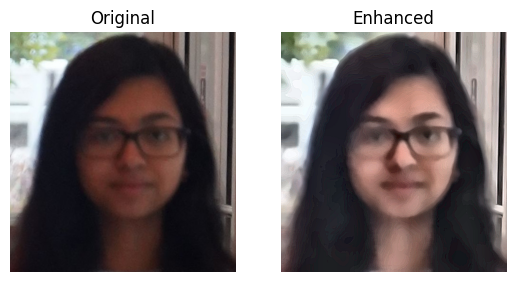

In [ ]:
img_path = "/content/drive/MyDrive/EECS5322_prj/Project 9 - attentive face recognition/queries/04_01.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print("========before========")
lap_var, brightness, contrast = compute_quality(img)
print(f"Sharpness: {lap_var:.2f}, Brightness: {brightness:.2f}, Contrast: {contrast:.2f}")

img_proc, Q_before = preprocess_image(img)
print(f"Processed image quality score Q was : {Q:.3f}")


print("""========After classics========
Sharpness: 875.15, Brightness: 85.08, Contrast: 69.16
Quality score new Q: 0.642""")

print("========After========")
lap_var, brightness, contrast = compute_quality(img_proc)
print(f"Sharpness: {lap_var:.2f}, Brightness: {brightness:.2f}, Contrast: {contrast:.2f}")
Q_new = compute_quality_score(lap_var, brightness, contrast)
print(f"Quality score new Q: {Q_new:.3f}")

# Optional: view before/after
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_proc)
plt.title("Enhanced")
plt.axis('off')
plt.show()


## add motion deblur

In [ ]:
import cv2
import numpy as np
from skimage import restoration, img_as_float

def richardson_lucy_deblur(img_rgb, psf, itter=20):
    """
    img_rgb: RGB image (uint8)
    psf: 2D point spread function (numpy array)
    itter: number of RL iterations
    """
    img_float = img_as_float(img_rgb)
    deblurred_channels = []
    for i in range(3):
        channel = img_float[:, :, i]
        deblurred = restoration.richardson_lucy(channel, psf, num_iter=itter)
        deblurred_channels.append(deblurred)
    deblurred_img = np.stack(deblurred_channels, axis=2)
    deblurred_img = np.clip(deblurred_img*255, 0, 255).astype(np.uint8)
    return deblurred_img

In [ ]:
def enhance_classical_v3(img_rgb, psf_size=15, rl_iterations=20):
    """
    Classical enhancement pipeline with Richardson-Lucy deblurring
    """
    # --- 1. Denoising ---
    bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    denoised = cv2.fastNlMeansDenoisingColored(bgr, None, 10, 10, 7, 21)
    img = cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB)

    # --- 2. CLAHE ---
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    L, A, B = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    L_clahe = clahe.apply(L)
    lab_clahe = cv2.merge((L_clahe, A, B))
    img = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

    # --- 3. Gamma correction ---
    img = adjust_gamma(img, gamma=1.2)

    # --- 4. Sharpening ---
    img = unsharp_mask(img, kernel_size=(5,5), sigma=1.0, amount=3.0)

    # --- 5. Richardson-Lucy deblurring ---
    psf = np.ones((psf_size, 1)) / psf_size  # create horizontal PSF
    img = richardson_lucy_deblur(img, psf=psf, itter=rl_iterations)

    return img

In [ ]:
def preprocess_image(img, lap_var_threshold=100.0):
    """
    Preprocess an image based on quality:
    - Compute quality metrics
    - If Laplacian variance < threshold, enhance image
    Returns:
        - processed image
        - quality score Q ∈ [0,1]
    """
    # Compute quality metrics
    lap_var, brightness, contrast = compute_quality(img)

    # Compute quality score
    Q = compute_quality_score(lap_var, brightness, contrast)

    # Apply enhancement if image is blurry
    if lap_var < lap_var_threshold:
        img = enhance_classical_v3(img)

    return img, Q


========before========
Sharpness: 27.09, Brightness: 67.96, Contrast: 65.35
Processed image quality score Q was : 0.303
========After classics========
Sharpness: 875.15, Brightness: 85.08, Contrast: 69.16
Quality score new Q: 0.642
========After========
Sharpness: 807.30, Brightness: 94.04, Contrast: 70.68
Quality score new Q: 0.667


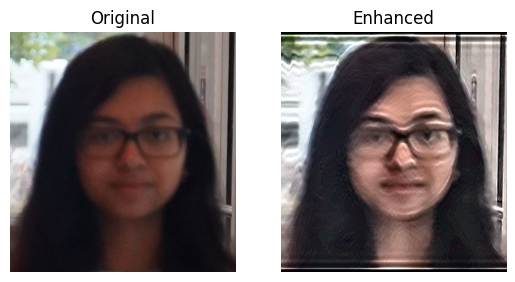

In [ ]:
img_path = "/content/drive/MyDrive/EECS5322_prj/Project 9 - attentive face recognition/queries/04_01.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print("========before========")
lap_var, brightness, contrast = compute_quality(img)
print(f"Sharpness: {lap_var:.2f}, Brightness: {brightness:.2f}, Contrast: {contrast:.2f}")

img_proc, Q_before = preprocess_image(img)
print(f"Processed image quality score Q was : {Q:.3f}")


print("""========After classics========
Sharpness: 875.15, Brightness: 85.08, Contrast: 69.16
Quality score new Q: 0.642""")

print("========After========")
lap_var, brightness, contrast = compute_quality(img_proc)
print(f"Sharpness: {lap_var:.2f}, Brightness: {brightness:.2f}, Contrast: {contrast:.2f}")
Q_new = compute_quality_score(lap_var, brightness, contrast)
print(f"Quality score new Q: {Q_new:.3f}")

# Optional: view before/after
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_proc)
plt.title("Enhanced")
plt.axis('off')
plt.show()


# final processing: the previous method decrease the metrics

In [ ]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Helper functions ---
def compute_quality(img_rgb):
    """Compute sharpness, brightness, and contrast of an RGB image"""
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    lap_var = cv2.Laplacian(gray, cv2.CV_64F).var()  # sharpness
    brightness = np.mean(gray)
    contrast = gray.std()
    return lap_var, brightness, contrast

def compute_quality_score(lap_var, brightness, contrast):
    """Simple normalized quality score"""
    # Normalize each metric to 0-1 scale (tunable)
    lap_norm = min(lap_var / 300.0, 1.0)
    bright_norm = min(brightness / 100.0, 1.0)
    contrast_norm = min(contrast / 100.0, 1.0)
    return (lap_norm + bright_norm + contrast_norm) / 3.0

def adjust_gamma(img, gamma=1.2):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255
                      for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(img, table)

def unsharp_mask(img, kernel_size=(3,3), sigma=0.8, amount=1.5):
    blurred = cv2.GaussianBlur(img, kernel_size, sigma)
    sharpened = cv2.addWeighted(img, 1 + amount, blurred, -amount, 0)
    return sharpened

# --- Minimal embedding-safe enhancement ---
def preprocess_image_v3(img_rgb, lap_var_thresh=100, brightness_thresh=50, contrast_thresh=50):
    """
    Enhance only low-quality images to improve embeddings:
    - Denoise
    - Mild CLAHE (contrast)
    - Mild gamma correction (brightness)
    """
    lap_var, brightness, contrast = compute_quality(img_rgb)
    Q = compute_quality_score(lap_var, brightness, contrast)
    img_proc = img_rgb.copy()
    enhanced = False

    if lap_var < lap_var_thresh or brightness < brightness_thresh or contrast < contrast_thresh:
        enhanced = True
        # Denoising
        bgr = cv2.cvtColor(img_proc, cv2.COLOR_RGB2BGR)
        denoised = cv2.fastNlMeansDenoisingColored(bgr, None, 10,10,7,21)
        img_proc = cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB)
        # CLAHE
        lab = cv2.cvtColor(img_proc, cv2.COLOR_RGB2LAB)
        L, A, B = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        L_clahe = clahe.apply(L)
        img_proc = cv2.cvtColor(cv2.merge((L_clahe,A,B)), cv2.COLOR_LAB2RGB)
        # Gamma correction
        img_proc = adjust_gamma(img_proc, gamma=1.2)

    return img_proc, Q, enhanced


### test

In [ ]:
import cv2
import numpy as np

# --- Existing helper functions ---
def compute_quality(img_rgb):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    lap_var = cv2.Laplacian(gray, cv2.CV_64F).var()  # sharpness
    brightness = np.mean(gray)
    contrast = gray.std()
    return lap_var, brightness, contrast

def compute_quality_score(lap_var, brightness, contrast):
    lap_norm = min(lap_var / 300.0, 1.0)
    bright_norm = min(brightness / 100.0, 1.0)
    contrast_norm = min(contrast / 100.0, 1.0)
    return (lap_norm + bright_norm + contrast_norm) / 3.0

def adjust_gamma(img, gamma=1.2):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255
                      for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(img, table)

def unsharp_mask(img, kernel_size=(3,3), sigma=0.8, amount=1.5):
    blurred = cv2.GaussianBlur(img, kernel_size, sigma)
    sharpened = cv2.addWeighted(img, 1 + amount, blurred, -amount, 0)
    return sharpened

# --- Optional lightweight super-resolution ---
def upscale_image(img_rgb, scale=2):
    """
    Simple OpenCV interpolation upscale (fast, embedding-safe)
    """
    h, w = img_rgb.shape[:2]
    return cv2.resize(img_rgb, (w*scale, h*scale), interpolation=cv2.INTER_CUBIC)

# --- Enhanced preprocessing pipeline ---
def preprocess_image_v4(img_rgb,
                        lap_var_thresh=50,
                        brightness_thresh=50,
                        contrast_thresh=50,
                        upscale=False):
    """
    Embedding-safe enhancement that selectively improves brightness, contrast, sharpness,
    and optionally resolution.
    """
    lap_var, brightness, contrast = compute_quality(img_rgb)
    Q = compute_quality_score(lap_var, brightness, contrast)
    img_proc = img_rgb.copy()
    enhanced = False

    # 1. Denoise (apply only if any metric is low)
    if lap_var < lap_var_thresh or brightness < brightness_thresh or contrast < contrast_thresh:
        enhanced = True
        bgr = cv2.cvtColor(img_proc, cv2.COLOR_RGB2BGR)
        denoised = cv2.fastNlMeansDenoisingColored(bgr, None, 10,10,7,21)
        img_proc = cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB)

   # 2. Contrast enhancement
    # 2. Contrast enhancement (brightness-preserving)
    if contrast < contrast_thresh:
        # Convert to LAB
        lab = cv2.cvtColor(img_proc, cv2.COLOR_RGB2LAB)
        L, A, B = cv2.split(lab)

        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
        L_clahe = clahe.apply(L)

        # Preserve original brightness
        mean_orig = L.mean()
        mean_new = L_clahe.mean()
        L_clahe = np.clip(L_clahe.astype(np.float32) - mean_new + mean_orig, 0, 255).astype(np.uint8)

        # Merge back and convert to RGB
        img_proc = cv2.cvtColor(cv2.merge((L_clahe, A, B)), cv2.COLOR_LAB2RGB)
        enhanced = True

        # Recompute contrast based on enhanced L channel
        contrast = L_clahe.std()


    # 3. Brightness enhancement
    if brightness < brightness_thresh:
        img_proc = adjust_gamma(img_proc, gamma=1.2)
        enhanced = True

    # 4. Sharpening (blur)
    if lap_var < lap_var_thresh:
        img_proc = unsharp_mask(img_proc, kernel_size=(3,3), sigma=0.8, amount=1.2)
        enhanced = True

    # 5. Optional resolution upscale
    if upscale:
        img_proc = upscale_image(img_proc, scale=2)
        enhanced = True

    return img_proc, Q, enhanced


## enhance query images

In [ ]:
enhanced_dir = Path("/content/drive/MyDrive/EECS5322_prj/enhanced_query_images/test")
enhanced_dir.mkdir(exist_ok=True)


img_paths = sorted(Path(WILD_IMG_DIR).glob("*.jpg"))

for img_path in tqdm(img_paths, desc="Processing wild set"):
        fname = img_path.name
        # true_id = int(query_labels[fname])
        img = load_image(img_path)  # user-defined function to read RGB image
        img_proc, Q_before, enhanced = preprocess_image_v4(img)
        save_path = enhanced_dir / img_path.name
        cv2.imwrite(str(save_path), cv2.cvtColor(img_proc, cv2.COLOR_RGB2BGR))

Processing wild set: 100%|██████████| 42/42 [00:14<00:00,  2.83it/s]


In [ ]:
def compute_image_quality(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    # Blur measure
    blur = cv2.Laplacian(img, cv2.CV_64F).var()
    # Brightness
    brightness = img.mean()
    # Contrast
    contrast = img.std()
    # Resolution
    resolution = img.shape[0] * img.shape[1]
    return blur, brightness, contrast, resolution

def analyze_dataset(image_dir, label):
    data = []
    for root, _, files in os.walk(image_dir):
        for f in files:
            if f.lower().endswith(('.jpg','.png','.jpeg')):
                path = os.path.join(root,f)
                metrics = compute_image_quality(path)
                if metrics:
                    blur, brightness, contrast, resolution = metrics
                    data.append({
                        'filename': f,
                        'blur': blur,
                        'brightness': brightness,
                        'contrast': contrast,
                        'resolution': resolution,
                        'set': label
                    })
    return pd.DataFrame(data)

In [ ]:
gallery_dir = "/content/drive/MyDrive/EECS5322_prj/Project 9 - attentive face recognition/gallery"
query_dir = enhanced_dir #"/content/drive/MyDrive/EECS5322_prj/Project 9 - attentive face recognition/queries"

df_gallery = analyze_dataset(gallery_dir, label="gallery")
df_query = analyze_dataset(query_dir, label="query")

df_quality = pd.concat([df_gallery, df_query], ignore_index=True)

# Save results
# df_quality.to_csv("/content/drive/MyDrive/EECS5322_prj/quality_assessment/" + "image_quality_metrics_after.csv", index=False)

/tmp/ipython-input-4125077947.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_quality[df_quality['set']=='gallery'][m], label='Gallery', shade=True, ax=ax)
/tmp/ipython-input-4125077947.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_quality[df_quality['set']=='query'][m], label='Query', shade=True, ax=ax)
/tmp/ipython-input-4125077947.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_quality[df_quality['set']=='gallery'][m], label='Gallery', shade=True, ax=ax)
/tmp/ipython-input-4125077947.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an err

Saved combined plot as /content/drive/MyDrive/EECS5322_prj/quality_assessment/all_metrics_dist_plot_abcd_after.png


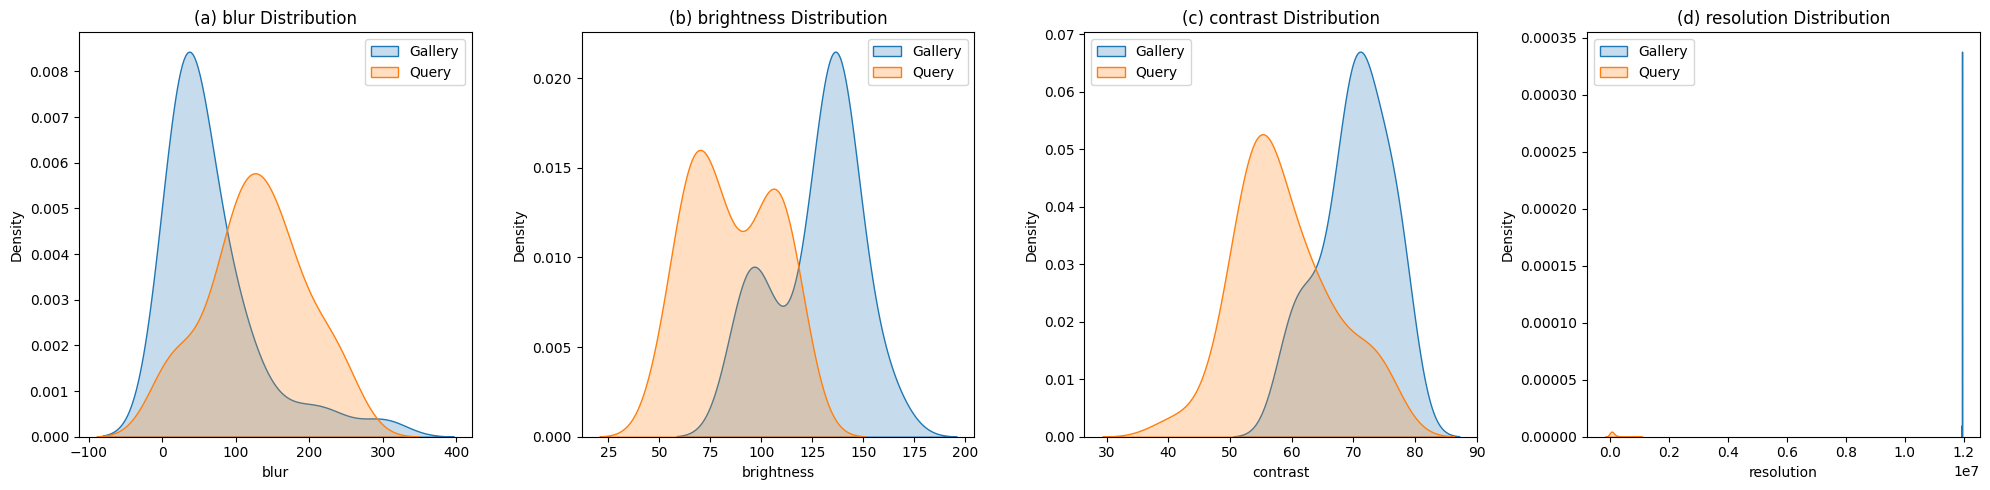

In [ ]:
# ------------------- Visualization -------------------
metrics = ['blur','brightness','contrast','resolution']
labels = ['(a)','(b)','(c)','(d)']

fig, axes = plt.subplots(1, 4, figsize=(20,5))  # 1 row, 4 columns

for ax, m, lbl in zip(axes, metrics, labels):
    sns.kdeplot(df_quality[df_quality['set']=='gallery'][m], label='Gallery', shade=True, ax=ax)
    sns.kdeplot(df_quality[df_quality['set']=='query'][m], label='Query', shade=True, ax=ax)
    ax.set_xlabel(m)
    ax.set_ylabel("Density")
    ax.set_title(f"{lbl} {m} Distribution")  # add a, b, c, d
    ax.legend()

plt.tight_layout()
fig_path = os.path.join("/content/drive/MyDrive/EECS5322_prj/quality_assessment", "all_metrics_dist_plot_abcd_after.png")
# plt.savefig(fig_path, dpi=300)
print(f"Saved combined plot as {fig_path}")
plt.show()


###

# process wild faces

In [ ]:
# --- Face identification ---
def identify_face(query_emb, gallery, open_set_threshold):
    best_id = 7  # default = no match
    best_score = -1e9

    for pid, embs in gallery.items():
        if len(embs) == 0:
            continue
        dists = np.linalg.norm(embs - query_emb, axis=1)
        score = -np.min(dists)
        if score > best_score:
            best_score = score
            best_id = pid

    if open_set_threshold is not None:
        if -best_score > open_set_threshold:
            return 7, best_score  # predict "no match"
    return best_id, best_score

In [ ]:
# --- Process wild set ---
def process_wild_set_v2(wild_img_dir, gallery, query_labels, open_set_threshold=0.95):
    rows = []
    img_paths = sorted(Path(wild_img_dir).glob("*.jpg"))

    for img_path in tqdm(img_paths, desc="Processing wild set"):
        fname = img_path.name
        true_id = int(query_labels[fname])
        img = load_image(img_path)  # user-defined function to read RGB image
        img_proc, Q_before, enhanced = preprocess_image_v3(img)
        emb = get_embedding(img_proc)  # user-defined embedding function

        if emb is None:
            pred_id, score, correct = 7, 0.0, int(true_id == 7)
        else:
            pred_id, score = identify_face(emb, gallery, open_set_threshold=open_set_threshold)
            correct = int(pred_id == true_id)

        rows.append({
            "filename": fname,
            "true_id": true_id,
            "pred_id": pred_id,
            "score": score,
            "correct": correct,
            "enhanced": enhanced,
            "Q_before": Q_before
        })

    return pd.DataFrame(rows)



In [ ]:
print("=== Processing Wild Set ===")
ground_truth_df = pd.read_csv(GROUND_TRUTH_CSV)
query_labels = dict(zip(ground_truth_df['filename'], ground_truth_df['True_ID']))
results = process_wild_set_v2(WILD_IMG_DIR, gallery, query_labels, open_set_threshold=1.1)
# results.to_csv(save_path + "quality_based_results_v2.csv", index=False)
print("Saved baseline_results.csv")

=== Processing Wild Set ===


Processing wild set: 100%|██████████| 42/42 [00:24<00:00,  1.70it/s]

Saved baseline_results.csv


# Evaluation

In [ ]:
# --- Evaluate ---
def evaluate_results(results_df, save_prefix="results", save_path=""):
    y_true = results_df['true_id']
    y_pred = results_df['pred_id']

    accuracy = (y_true == y_pred).mean()
    precision = results_df.loc[y_pred != 7, 'correct'].mean() if len(results_df.loc[y_pred != 7])>0 else 0
    recall = results_df.loc[y_true != 7, 'correct'].mean() if len(results_df.loc[y_true != 7])>0 else 0

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (gallery matches only): {precision:.4f}")
    print(f"Recall (gallery matches only): {recall:.4f}")

    # Optional: visualizations (confusion matrix, score distributions, PR curve)
    return accuracy, precision, recall

In [ ]:
print("=== Evaluating Precision–Recall ===")
# save_path = "/content/drive/MyDrive/EECS5322_prj/1_0.8_threshold/"
accuracy, precision, recall= evaluate_results(results, "/content/drive/MyDrive/EECS5322_prj/Part2_data/")
# print(f"Baseline Average Precision (AP): {ap:.4f}")

=== Evaluating Precision–Recall ===
Accuracy: 0.8095
Precision (gallery matches only): 0.8065
Recall (gallery matches only): 0.8333


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import precision_recall_curve, average_precision_score

def evaluate_and_visualize(results_df, save_prefix="results", save_path = ""):
    """
    Computes metrics and generates multiple diagrams:
    - Multi-class confusion matrix
    - Per-ID accuracy bar chart
    - Score distributions
    - Precision-recall curve
    """

    # ------------------- Metrics -------------------
    y_true = results_df['true_id']
    y_pred = results_df['pred_id']

    labels = [0,1,2,3,4,5,6,7]  # 0-6 gallery, 7=no match
    accuracy = (y_true == y_pred).mean()
    precision = (results_df.loc[y_pred != 7, 'correct'].mean()) if len(results_df.loc[y_pred != 7])>0 else 0
    recall = (results_df.loc[y_true != 7, 'correct'].mean()) if len(results_df.loc[y_true != 7])>0 else 0

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (gallery matches only): {precision:.4f}")
    print(f"Recall (gallery matches only): {recall:.4f}")

    # ------------------- Multi-class confusion matrix -------------------
    cm = pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], dropna=False)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix (0-6: gallery, 7: no match)")
    plt.tight_layout()
    plt.savefig( str(save_path) + str(save_prefix) + "_confusion_matrix.png")
    plt.close()

    # ------------------- Per-ID accuracy -------------------
    per_id_acc = results_df.groupby('true_id')['correct'].mean()
    plt.figure(figsize=(6,4))
    per_id_acc.plot(kind='bar', color='skyblue')
    plt.ylabel("Accuracy")
    plt.xlabel("Identity")
    plt.title("Per-ID Accuracy")
    plt.tight_layout()
    plt.savefig(str(save_path) + str(save_prefix) + "_per_id_accuracy.png")
    plt.close()

    # ------------------- Score distributions -------------------
    plt.figure(figsize=(6,4))
    sns.histplot(results_df[results_df['correct']==1]['score'], color='green', label='Correct', kde=True)
    sns.histplot(results_df[results_df['correct']==0]['score'], color='red', label='Incorrect', kde=True)
    plt.xlabel("Similarity Score (Negative L2)")
    plt.ylabel("Count")
    plt.title("Score Distribution: Correct vs Incorrect")
    plt.legend()
    plt.tight_layout()
    plt.savefig(str(save_path) + str(save_prefix)+ "_score_distribution.png")
    plt.close()

    # ------------------- Precision-Recall Curve -------------------
    y_true_bin = results_df['correct'].values
    y_scores = results_df['score'].values
    precision_vals, recall_vals, thresholds = precision_recall_curve(y_true_bin, y_scores)
    ap = average_precision_score(y_true_bin, y_scores)

    plt.figure(figsize=(6,6))
    plt.plot(recall_vals, precision_vals, label=f"AP = {ap:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(str(save_path) + str(save_prefix)+"_pr_curve.png")
    plt.close()

    # ------------------- Save predictions -------------------
    results_df.to_csv(str(save_path) + str(save_prefix)+"_predictions.csv", index=False)
    print(f"Predictions saved as {save_prefix}_predictions.csv")
    print(f"All diagrams saved with prefix {save_prefix}_*.png")

    return accuracy, precision, recall, cm, per_id_acc


In [ ]:
print("=== Evaluating Precision–Recall ===")
# save_path = "/content/drive/MyDrive/EECS5322_prj/1_0.8_threshold/"
acc, prec, rec, cm, per_id_acc = evaluate_and_visualize(results, "/content/drive/MyDrive/EECS5322_prj/Part2_data/")
# print(f"Baseline Average Precision (AP): {ap:.4f}")

=== Evaluating Precision–Recall ===
Accuracy: 0.8095
Precision (gallery matches only): 0.8065
Recall (gallery matches only): 0.8333
Predictions saved as /content/drive/MyDrive/EECS5322_prj/Part2_data/_predictions.csv
All diagrams saved with prefix /content/drive/MyDrive/EECS5322_prj/Part2_data/_*.png


Before:

=== Evaluating Precision–Recall ===

Accuracy: 0.5238

Precision (gallery matches only): 1.0000

Recall (gallery matches only): 0.3333

---------------
run 2:

=== Evaluating Precision–Recall ===
Accuracy: 0.6905

Precision (gallery matches only): 0.9444

Recall (gallery matches only): 0.5667

Most pretrained face embedding models (FaceNet, ArcFace, etc.) are robust to small quality variations.

When you denoise, apply CLAHE, gamma correction, or sharpen, you change the pixel distribution.

Even mild changes can shift embeddings enough to reduce matching accuracy, because L2/cosine distances are very sensitive to the exact feature vector.

processing version 3: increase brightness and contrast soft on rest

=== Evaluating Precision–Recall ===

Accuracy: 0.8095

Precision (gallery matches only): 0.8065

Recall (gallery matches only): 0.8333

# readjust open-set threshold

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distance_distributions(results_df, save_path):
    """
    Plot histograms of minimum distances for known gallery vs unknown queries
    to help choose an open-set threshold.
    """
    # Compute negative score to distance
    results_df['min_dist'] = -results_df['score']

    # Separate known vs unknown
    known = results_df[results_df['true_id'] != 7]['min_dist']
    unknown = results_df[results_df['true_id'] == 7]['min_dist']

    plt.figure(figsize=(8,6))
    sns.histplot(known, color='green', label='Known (gallery)', kde=True, bins=30)
    sns.histplot(unknown, color='red', label='Unknown (not in gallery)', kde=True, bins=30)
    plt.xlabel("Minimum L2 Distance to Gallery")
    plt.ylabel("Count")
    plt.title("Distance Distribution for Known vs Unknown Queries")
    plt.axvline(x=known.mean(), color='green', linestyle='--', label="Known Mean")
    plt.axvline(x=unknown.mean(), color='red', linestyle='--', label="Unknown Mean")
    plt.legend()
    plt.tight_layout()
    plt.show()
    # plt.savefig(save_path)
    plt.close()
    print(f"Distance distribution plot saved as {save_path}")


In [ ]:
results = process_wild_set(WILD_IMG_DIR, gallery, query_labels, open_set_threshold=None)

# Plot distance distributions to visualize separation
plot_distance_distributions(results, save_path=save_path + "/distance_distributions_part2.png")


Processing wild set: 100%|██████████| 42/42 [00:38<00:00,  1.09it/s]


Distance distribution plot saved as /content/drive/MyDrive/EECS5322_prj//distance_distributions_part2.png


threshold is 1.1